In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

# data load

## 뉴스데이터

In [2]:
path = '..\데이터\기업별 뉴스'

In [3]:
import os
file_list = os.listdir(path)
len(file_list)

140

In [4]:
file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    # else:
    #     for k in range(len(file)-1,0,-1):
    #         if file[k]=='.':
    #             file_name.append(file[:k])
    #             break

In [5]:
file_name[:5]

['CMG제약', 'HLB생명과학', 'JW생명과학', 'JW신약', 'JW중외제약']

In [6]:
df1 = []
for 기업 in file_name:
    df =pd.read_excel(f"../데이터/기업별 뉴스/{기업}.xlsx",sheet_name='#02 Documents')#,header=0,skiprows=[1,2])
    # df = df[['Unnamed: 2','20221231','20211231','20201231','20191231','20181231']]
    df = pd.DataFrame(df)
    df1.append(df)
len(df1)

140

In [7]:
df2 =[]
for df in df1:
    df = df[['title','polarity.label']]
    df['polarity.label'] = df['polarity.label'].replace(-1,2)
    # dupli = df[df.duplicated()]
    df.drop_duplicates(subset=['title'], inplace=True)
    df2.append(df)
    # duplicate_list.append(dupli)

In [8]:
len(df2)

140

In [9]:
df2[49].head(2)

,title,polarity.label
0,[취재 일지]세계는 여전히 ‘건기식’ 열풍… 경쟁력 높이려면 식약처 기준 완화돼야,NaN
1,"어린이 프로바이오틱스, 유산균도 가격도 천차만별…따져보고 사야",NaN


In [10]:
train = []
test  = []
for df in df2:
    tmp_train = df[df['polarity.label'].notna()]
    tmp_test = df[df['polarity.label'].isna()]
    train.append(tmp_train)
    test.append(tmp_test)

In [11]:
len(train), len(test)

(140, 140)

In [12]:
mecab = mecab.MeCab()

In [13]:
test1 =[]
for df in test:
    df['tokenized'] = df['title'].apply(mecab.morphs)
    df['labels'] = df['polarity.label']
    df = df[['labels','tokenized']]
    test1.append(df)

In [14]:
test1[0].head(2)

,labels,tokenized
0,NaN,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,NaN,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."


## concat

In [15]:
test_df = pd.concat(test1, axis = 0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22828 entries, 0 to 411
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   labels     0 non-null      float64
 1   tokenized  22828 non-null  object 
dtypes: float64(1), object(1)
memory usage: 535.0+ KB


In [16]:
X_test = test_df['tokenized']
y_test = test_df['labels']

In [17]:
# X_test

# 토크나이즈

In [18]:
X_train = pd.read_csv('./X_train.csv')
X_train = X_train['tokenized']

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[75, 20, 206, 33, 1, 1, 3583, 3289, 352, 1630, 6, 89, 3048, 12, 1077, 9880, 783, 36, 3289, 9881, 768], [1, 1, 32, 51, 21, 26, 361, 19, 1, 1, 348, 2, 9882, 5, 2392, 1, 1, 5855, 13, 59, 1689, 9883, 9884, 89, 57, 107, 36], [1, 1, 39, 14, 1, 1, 1159, 536, 5, 333, 1, 1, 21, 53, 46, 132, 769, 2, 21, 1, 1, 120, 96], [126, 264, 1878, 63, 1, 1, 183, 609, 134, 112, 2024, 13, 27, 2, 151], [61, 4, 702, 52, 134, 43, 2668, 1043, 406, 3, 340, 16, 173, 26, 232, 19, 1211, 4, 183, 214, 43, 2668, 1043, 1, 1, 1327, 1, 1, 3290, 1, 1, 1, 1, 23, 1580, 11, 3584, 129, 379, 9, 183, 334, 67, 63, 2, 57, 3934, 2243, 266, 24, 219, 702, 24, 89, 18, 3, 57, 11, 398, 28, 145, 186, 7, 1, 1]]
[[], [], [], [4359], [1, 1]]


In [20]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

17679


# 패딩

본문의 최대 길이 : 465
본문의 평균 길이 : 103.7814891755959


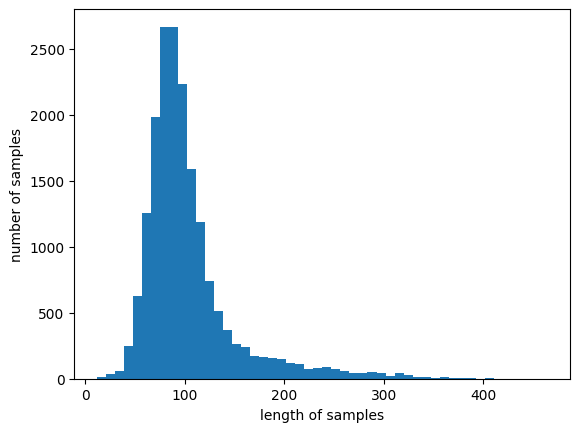

In [21]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
max_len = 465

In [23]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [24]:
X_train_encoded.shape

(18292, 465)

In [25]:
y_test.shape

(22828,)

# 모델

In [27]:
model = load_model('best_model.h5')

In [28]:
predict=model.predict(X_test_encoded)

714/714 [==============================] - 37s 47ms/step


In [29]:
for predict in predict:
    labels = np.argmax(predict)

In [30]:
test_df['labels'] = labels

In [31]:
test_df.head()

,labels,tokenized
0,0,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,0,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."
6,0,"[오늘, 은, ‘, 세계, 강아지, 의, 날, ’, “, 반려, 견, 건강, 챙겨,..."
7,0,"[펫, 의약품, 가파른, 성장세, …, 제약, ·, 바이오, 기업, 바빠졌, 다]"
8,0,"[안국, 약품, ,, CMG, 제약, 과, 고, 혈압, ·, 고지혈증, 복합제, '..."


In [35]:
test_df[test_df['labels']==0]

,labels,tokenized
0,0,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,0,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."
6,0,"[오늘, 은, ‘, 세계, 강아지, 의, 날, ’, “, 반려, 견, 건강, 챙겨,..."
7,0,"[펫, 의약품, 가파른, 성장세, …, 제약, ·, 바이오, 기업, 바빠졌, 다]"
8,0,"[안국, 약품, ,, CMG, 제약, 과, 고, 혈압, ·, 고지혈증, 복합제, '..."
...,...,...
402,0,"[정일문, 한국, 투자, 증권, 사장, ', 덕분, 에, 챌린지, ', 동참]"
403,0,"[휴, 온스, 메디케어, ,, IPO, 절차, 돌입, …, "", 내년, 코스닥, 상..."
409,0,"[휴, 온스, 메디케어, ,, 성남, 지식, 산업, 센터, 에, ', 새, 둥지, ']"
410,0,"[휴, 온스, 메디케어, ,, 성남, 지식, 산업, 센터, 에, ‘, 새, 둥지, ’]"


In [38]:
test_df[test_df['labels']==1]

,labels,tokenized
